In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import uncertainties as un
import mrmr
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [2]:
signal = pd.read_csv('data_local/signal_train.csv', sep=',')
background = pd.read_csv('data_local/background_train.csv', sep=',')

## Preprocessing

In [3]:
df = pd.concat((signal, background))

for feature in df.columns.values: ## remove MC truths
    if "Weight" in feature:
        df.drop(columns=[feature], inplace=True)
    elif "MC" in feature:
        df.drop(columns=[feature], inplace=True)
    elif "Corsika" in feature: 
        df.drop(columns=[feature], inplace=True)
    elif "I3EventHeader" in feature:
        df.drop(columns=[feature], inplace=True)

df.replace({np.inf: np.nan, -np.inf: np.nan}, value=None, inplace=True) # inf to nan
for feauture in df.columns.values: 
    if df[feauture].isna().sum() > 0.1*len(df[feauture]): # drop columns with many nans
        df.drop(columns=[feauture], inplace=True)
df.dropna(axis=0, how="any", inplace=True) # drop any rows left with nans

label = df["label"]
df.drop(columns=["label"], inplace=True)
keys = df.columns.values

scaler = StandardScaler() # rescale the data
X = scaler.fit_transform(df)
df = pd.DataFrame(X, columns=keys)

## Feauture selection

In [4]:
feautures_class = mrmr.mrmr_classif(X=df, y=label, K=100) ## determine the best 100 features in order  

100%|██████████| 100/100 [00:15<00:00,  6.26it/s]


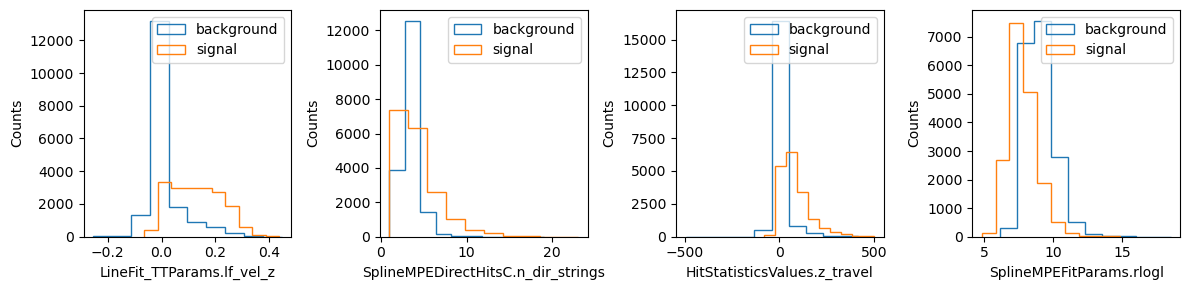

In [5]:
num_plots = 4
plt.figure(figsize=(12,3))
for i in range(num_plots):
    plt.subplot(1,num_plots,i+1)
    plt.hist(background[feautures_class[i]], histtype = "step", label = "background")
    plt.hist(signal[feautures_class[i]], histtype = "step", label = "signal")
    plt.xlabel(feautures_class[i])
    plt.ylabel("Counts")
    plt.tight_layout()
    plt.legend()
    plt.savefig("build/features.pdf")

## Model training

In [187]:
def num_features(model, model_name):
    
    n_feat = [5,10,20,30,40,50,60,70,80,90,100]

    accuracy = []
    precision = []
    roc_auc = []

    print(f"{model_name}:")
    for n in n_feat:
        X = df[feautures_class[:n]]
        X_train, X_test, y_train, y_test = train_test_split(X, label, test_size = 0.5, random_state = 69)
        model.fit(X_train, y_train)
        y_predict = model.predict(X_test)

        accuracy.append( accuracy_score(y_test, y_predict) )
        precision.append( precision_score(y_test, y_predict) )
        roc_auc.append( roc_auc_score(y_test, y_predict) )
        print(f"Tried {n} features")

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.scatter(n_feat ,accuracy)
    plt.xlabel("Number of features")
    plt.ylabel("Accuracy")
    plt.subplot(1,3,2)
    plt.scatter(n_feat, precision)
    plt.xlabel("Number of features")
    plt.ylabel("Precision")
    plt.subplot(1,3,3)
    plt.scatter(n_feat, roc_auc)
    plt.xlabel("Number of features")
    plt.ylabel("ROC Score")
    plt.tight_layout()
    plt.savefig(f"build/{model_name}/{model_name}_features.pdf")
    plt.close()

def model_eval(model, model_name, n_feautures, beta, tau_range, tau_plot):
    X = df[feautures_class[:n_feautures]] ## take n feautures only
    kfold = KFold(n_splits=5, shuffle=True) ## kfolding with shuffling
    cv_result = cross_validate(model, X, label, scoring=["accuracy", "precision", "roc_auc"], cv = kfold, return_estimator=True)
    print("")
    print(f"{model_name} Cross validation result:")
    print(f"Accuracy: {un.ufloat(np.mean(cv_result['test_accuracy']),np.std(cv_result['test_accuracy']))}")
    print(f"Precision: {un.ufloat(np.mean(cv_result['test_precision']),np.std(cv_result['test_precision']))}")
    print(f"ROC: {un.ufloat(np.mean(cv_result['test_roc_auc']),np.std(cv_result['test_roc_auc']))}")
    print("")

    model_fitted = cv_result["estimator"][0] ## use one of the fitted models
    y_predict_proba = model_fitted.predict_proba(X)
    plt.hist(y_predict_proba[:,1], bins = 50)
    plt.xlabel("Predicted probability")
    plt.ylabel("Counts")
    plt.tight_layout()
    plt.savefig(f'build/{model_name}/{model_name}_predproba.pdf')
    plt.close()

    precision = [] 
    recall = []
    f_beta = []
    threshold = np.linspace(tau_range[0],tau_range[1],100)
    for tau_c in threshold:
        y_predict = (y_predict_proba[:,1] > tau_c).astype(int)
        c_mat = confusion_matrix(label, y_predict)
        TP = c_mat[1][1]
        FP = c_mat[0][1]
        TN = c_mat[0][0]
        FN = c_mat[1][0]
        p = TP/(TP+FP)
        precision.append(p)
        r = TP/(TP+FN)
        recall.append(r)
        if r == 0:
            f_beta.append(f)
        else:
            f = (1+beta**2)*( (p*r)/(beta**2*p+r) )
            f_beta.append(f)

    plt.plot(np.linspace(0,1,100), precision, label = "precision")
    plt.plot(np.linspace(0,1,100), recall, label = "recall")
    plt.xlabel(r"$\tau_c$")
    plt.tight_layout()
    plt.legend()
    plt.savefig(f"build/{model_name}/{model_name}_recall_precision.pdf")
    plt.close()

    tau_best = threshold[np.argmax(f_beta)]
    plt.plot(threshold, f_beta, label = r"$f_{\beta}$")
    plt.vlines(tau_best, 0,1, label = r"$\tau_c$ best= "+f"{np.around(tau_best,decimals=4 )}", linestyle = "dashed", color = "gray")
    plt.ylim(tau_plot[0], tau_plot[1])
    plt.xlabel(r"$\tau_c$")
    plt.tight_layout()
    plt.legend()
    plt.savefig(f"build/{model_name}/{model_name}_threshold.pdf")
    plt.close()

    y_predict = (y_predict_proba[:,1] > tau_best).astype(int)
    c_mat = confusion_matrix(label, y_predict)
    ax = sn.heatmap(c_mat, annot=True, cmap = "Blues", fmt='g',cbar_kws={'label': 'Counts'})
    ax.set(xlabel="Actual label", ylabel="Predicted label")
    plt.tight_layout()
    plt.savefig(f'build/{model_name}/{model_name}_confusion.pdf')
    plt.close()

    FP, TP, _ = roc_curve(label, y_predict_proba[:,1], pos_label=1) ## roc curve

    return model_fitted,FP,TP,tau_best

## Naive Bayes

In [188]:
num_features(GaussianNB(), "Naive_Bayes")

Naive_Bayes:
Tried 5 features
Tried 10 features
Tried 20 features
Tried 30 features
Tried 40 features
Tried 50 features
Tried 60 features
Tried 70 features
Tried 80 features
Tried 90 features
Tried 100 features


In [189]:
NB, FP_NB, TP_NB, tau_NB = model_eval(GaussianNB(), "Naive_Bayes", 5, beta = 0.1, tau_range=[0.995,1], tau_plot=[0.93,0.95])


Naive_Bayes Cross validation result:
Accuracy: 0.8431+/-0.0025
Precision: 0.9076+/-0.0034
ROC: 0.9277+/-0.0018



## Random Forest

In [182]:
num_features(RandomForestClassifier(100), "Random_Forest")

Random_Forest:
Tried 5 features
Tried 10 features
Tried 20 features
Tried 30 features
Tried 40 features
Tried 50 features
Tried 60 features
Tried 70 features
Tried 80 features
Tried 90 features
Tried 100 features



Random_Forest Cross validation result:
Accuracy: 0.9732+/-0.0013
Precision: 0.9867+/-0.0009
ROC: 0.9957+/-0.0007



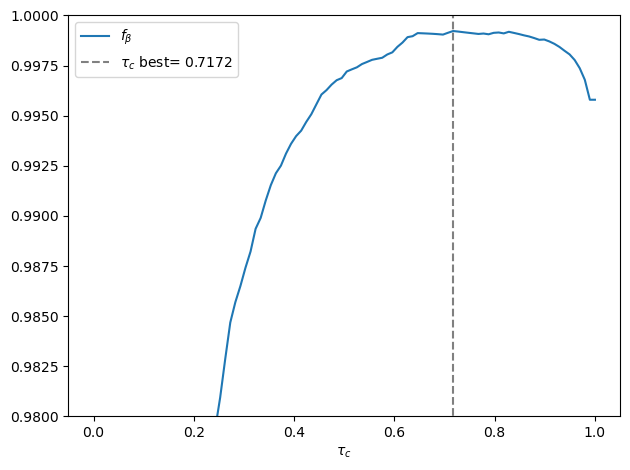

In [183]:
#RF, FP_RF, TP_RF, tau_RF = model_eval(RandomForestClassifier(10, max_depth=10), "Random Forest", 60, beta = 0.1)
RF, FP_RF, TP_RF, tau_RF = model_eval(RandomForestClassifier(100), "Random_Forest", 60, beta = 0.1, tau_range=[0,1], tau_plot=[0.98,1])

## Neural Network

In [184]:
num_features(MLPClassifier((60,10)), "Neural_Network")

Neural_Network:
Tried 5 features
Tried 10 features
Tried 20 features
Tried 30 features
Tried 40 features
Tried 50 features
Tried 60 features
Tried 70 features
Tried 80 features
Tried 90 features
Tried 100 features



Neural_Network Cross validation result:
Accuracy: 0.9714+/-0.0021
Precision: 0.973+/-0.005
ROC: 0.99612+/-0.00031



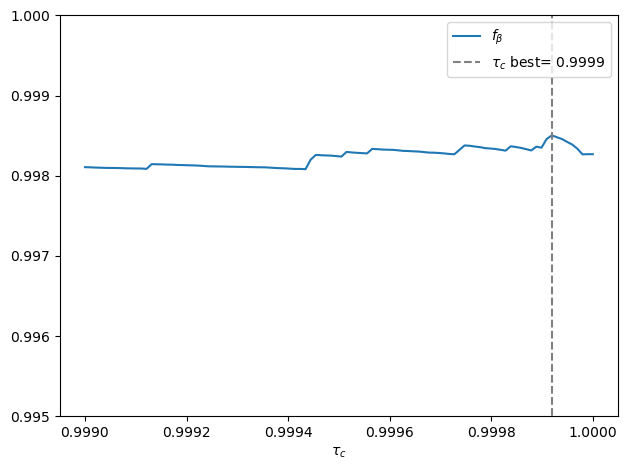

In [186]:
NN, FP_NN, TP_NN, tau_NN = model_eval(MLPClassifier((60,10)), "Neural_Network", 60, beta = 0.1, tau_range=[0.999,1], tau_plot=[0.995,1])

## Comparing Classifiers

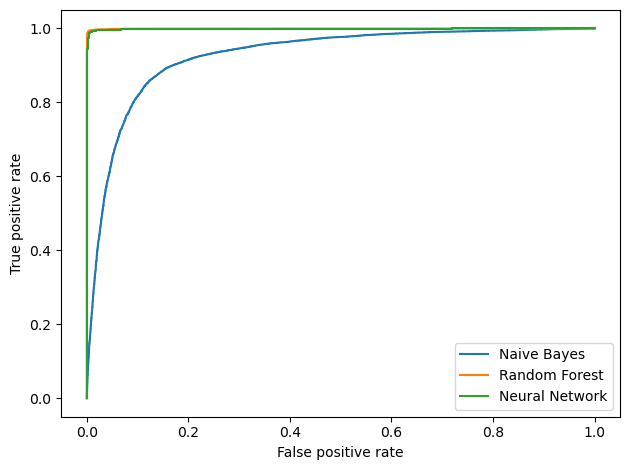

In [191]:
plt.plot(FP_NB, TP_NB, label = "Naive Bayes")
plt.plot(FP_RF, TP_RF, label = "Random Forest")
plt.plot(FP_NN, TP_NN, label = "Neural Network")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend()
plt.tight_layout()
plt.savefig("build/roc_curves.pdf")

## Predicting on test data

In [192]:
## Random forest performes the best so lets use it
n=60
test = pd.read_csv('data_local/test.csv', sep=',')
X = test[keys]
X = scaler.transform(X)
X = pd.DataFrame(X, columns=keys)
X = X[feautures_class[:n]]
X.replace(to_replace=np.nan, value=0, inplace=True) # stoopid nan
y_predict_proba = RF.predict_proba(X)
labels_predicted = (y_predict_proba[:,1] > tau_RF).astype(int)
print(f"Found {np.sum(labels_predicted)} signal events.")
print(f"Remaining {len(labels_predicted)-np.sum(labels_predicted)} events are background.")
result = pd.DataFrame(labels_predicted, columns=["label"])
result.to_csv("build/result.csv")
result

Found 1922 signal events.
Remaining 2078 events are background.


,label
0,1
1,0
2,0
3,0
4,0
...,...
3995,0
3996,0
3997,0
3998,0


Jorking